In [235]:
import new_files
import json
import pickle
import numpy as np
import nibabel as nb
import trimesh
import open3d as o3d
import networkx as nx
import matplotlib.pylab as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import colors

In [283]:
def custom_draw_geometry(mesh, filename="render.png", visible=True, wh=[960, 960], save=True):
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=wh[0], height=wh[1], visible=visible)
    if isinstance(mesh, list):
        for i in mesh:
            vis.add_geometry(i)
    else:
        vis.add_geometry(mesh)
    vis.get_render_option().mesh_show_back_face=True
    vis.get_render_option().light_on=True
    vis.run()
    if save:
        vis.capture_screen_image(filename, do_render=True)
    vis.destroy_window()

In [11]:
dir_search = new_files.Files()
dataset_path = "/home/common/bonaiuto/multiburst/derivatives/processed"
img_path = "/scratch/poster_visualisations"
all_jsons = dir_search.get_files(dataset_path,"*.json", strings=["info"])

In [12]:
json_file = all_jsons[0]
with open(json_file) as pipeline_file:
    info = json.load(pipeline_file)

In [259]:
atlas_colours = np.load(info["atlas_colors_path"])
atlas_labels = np.load(info["atlas_labels_path"])
atlas_labels = np.array([i.decode("utf=8") for i in atlas_labels])

In [42]:
def box(colour, pos):
    obj = o3d.geometry.TriangleMesh.create_sphere(
        radius=0.3, resolution=10,
        create_uv_map=True
    )
    obj.paint_uniform_color(colour)
    obj.translate(pos)
    return obj

In [46]:
visual_epo_file = "/scratch/poster_visualisations/data_csd_power_autoreject-sub-001-ses-01-001-motor-epo.pickle"
motor_epo_file = "/scratch/poster_visualisations/data_csd_power_autoreject-sub-001-ses-01-001-visual-epo.pickle"

In [49]:
with (open(visual_epo_file, "rb")) as file:
    data = pickle.load(file)

In [52]:
data["log_variance"].shape

(32166,)

In [231]:
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
vx_neighbours = mesh.vertex_neighbors
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
gray = np.array([0.5, 0.5, 0.5])
blue = np.array([0, 0.75, 1])
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
colours[map_perc] = blue
mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
shapes = [mesh]
custom_draw_geometry(shapes, save=False)

In [278]:
brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
vx_neighbours = mesh.vertex_neighbors
map_perc = data["log_variance"] >= np.percentile(data["log_variance"], 99)
vx_neighbours = [np.array(i) for i in vx_neighbours]
removed_mesh = np.arange(vertices.shape[0])[map_perc]
removed_mesh_neighbours = [np.intersect1d(vx_neighbours[i], removed_mesh) for i in removed_mesh]
dict_mesh = {i[0]: i[1] for i in list(zip(removed_mesh, removed_mesh_neighbours)) if len(i[1]) > 0}
vv_graph = nx.from_dict_of_lists(dict_mesh)
all_clusters = {i: np.sort(np.array(list(nx.node_connected_component(vv_graph, i)))) for i in list(dict_mesh)}
unique_clusters = {}
for val in list(all_clusters.values()):
    if unique_clusters.get(tuple(val)) == None:
        keys = [i for i in list(all_clusters.keys()) if comp_np_arr(all_clusters[i], val)]
        unique_clusters[tuple(val)] = len(keys)

unique_clusters = [np.array(i) for i in list(unique_clusters.keys())]
unique_clusters = [i for i in unique_clusters if i.shape[0] > 4]

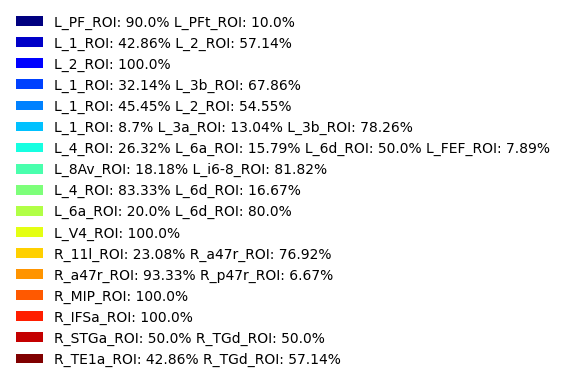

In [298]:
cluster_no = len(unique_clusters)
cm = plt.colormaps["jet"]
col_val = np.linspace(0,1,num=cluster_no)
label_colours = cm(col_val)[:,:3]
legend_items = []

cluster_desc = {}
for ix, lab in enumerate(col_val):
    labs, counts = np.unique(atlas_labels[unique_clusters[ix]], return_counts=True)
    cluster_desc[ix] = []
    for ixx, lab in enumerate(labs):
        la = "{}: {}% ".format(lab, np.round(counts[ixx]/np.sum(counts)*100, 2))
        cluster_desc[ix].append(la)
    
    p = Patch(
        facecolor=label_colours[ix],
        label="".join(cluster_desc[ix])[:-1]
    )
    legend_items.append(p)
f, ax = plt.subplots(figsize=(3,2))
ax.legend(handles=legend_items, loc="center", frameon=False)
ax.axis("off");

In [299]:
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
gray = np.array([0.5, 0.5, 0.5])
blue = np.array([0, 0.75, 1])
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)

for ix, pp in enumerate(unique_clusters):
    colours[pp] = label_colours[ix]

mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
shapes = [mesh]
custom_draw_geometry(shapes, save=False)

In [203]:
def comp_np_arr(ar1, ar2):
    if ar1.shape == ar2.shape:
        return np.all(ar1 == ar2)
    elif ar1.shape != ar2.shape:
        return False
    else:
        return False

In [266]:
labs, counts = np.unique(atlas_labels[unique_clusters[0]], return_counts=True)

cluster_desc = {}
cluster_desc[0] = []
for ix, lab in enumerate(labs):
    la = "{}: {}% ".format(lab, counts[ix]/np.sum(counts)*100)
    cluster_desc[0].append(la)
    

In [295]:
brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
gray = np.array([0.5, 0.5, 0.5])
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)

prc_range = [90, 92.5, 95, 97.5, 99]
cm = plt.colormaps["magma_r"]
col_val = np.linspace(0, 0.5,num=len(prc_range)-1)
col_val = np.append(col_val, 1)
label_colours = cm(col_val)[:,:3]

for ix, pr in enumerate(prc_range):
    map_perc = data["log_variance"] >= np.percentile(data["log_variance"], pr)
    colours[map_perc] = label_colours[ix]

mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
shapes = [mesh]
custom_draw_geometry(shapes, save=False)

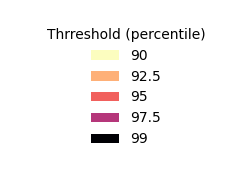

In [296]:
prc_range = [90, 92.5, 95, 97.5, 99]
cm = plt.colormaps["magma_r"]
col_val = np.linspace(0, 0.5,num=len(prc_range)-1)
col_val = np.append(col_val, 1)
label_colours = cm(col_val)[:,:3]

legend_items = []
for ix, lab in enumerate(prc_range):
    p = Patch(
        facecolor=label_colours[ix],
        label="{}".format(lab)
    )
    legend_items.append(p)
f, ax = plt.subplots(figsize=(3,2))
ax.legend(handles=legend_items, loc="center", frameon=False, title="Thrreshold (percentile)")
ax.axis("off");